# Video Action Recognition - 3D CNN

## Setup

### Google Colab Setup

In [ ]:
!git clone https://github.com/bhavyaajani/videoactionrecognition

### Python Imports

In [ ]:
#Generic imports
import os
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

#TF specific imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

print(gpu_devices[0])
print(tf.__version__)

### Definitions

In [ ]:
#External directories defined here!

root_data_dir = r'/content/videoactionrecognition/Data'
model_dir = r'/content/Model'
tensorboard_dir = r'/content/TensorBoard'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
        
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)

!ls

In [ ]:
#Constants

SEQ_SIZE = 12
BATCH_SIZE = 16
SHAPE = [224,224,3]

## Data

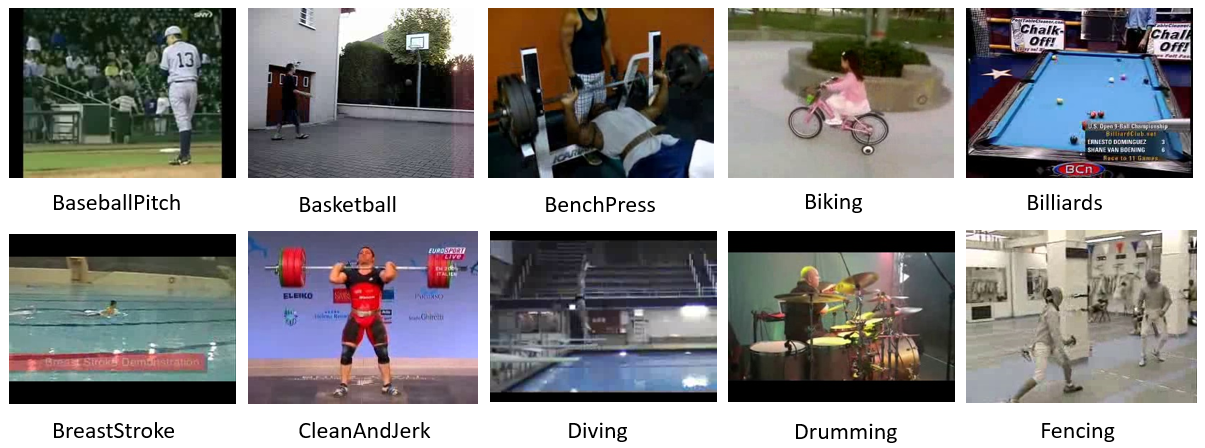

In [ ]:
CLASSES = 10
label_2_idx_dict = {'BaseballPitch':0,'Basketball':1,'BenchPress':2,'Biking':3,'Billiards':4,'BreastStroke':5,'CleanAndJerk':6,
                'Diving':7,'Drumming':8,'Fencing':9}

def ohot_2_label(ohot):
    return [label for label, idx in label_2_idx_dict.items() if idx == np.argmax(ohot)][0]

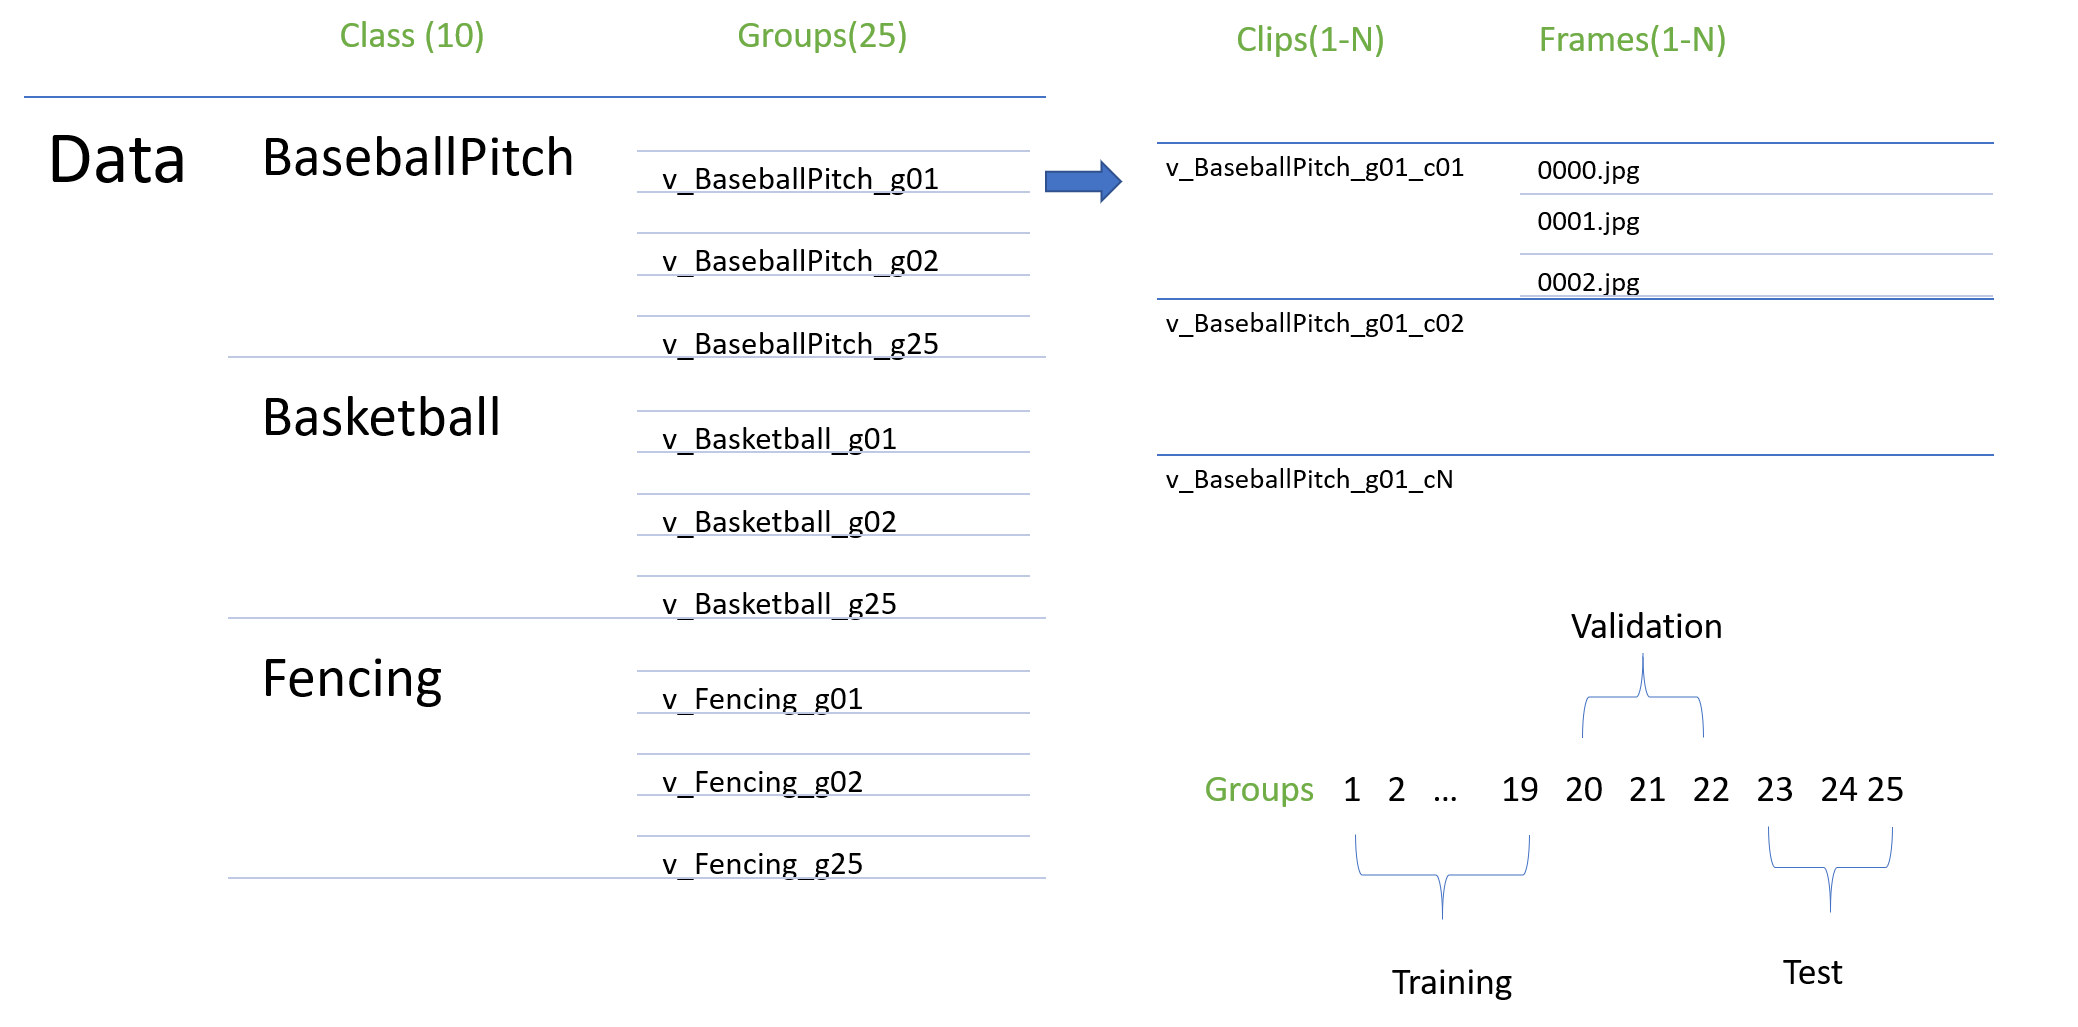

In [ ]:
def SplitClassGroupData(class_dir_list):
    train_groups=[]
    test_groups=[]
    val_groups=[]
    
    for class_dir in class_dir_list:
        group_dir_list= sorted(glob.glob(class_dir+"/**"))
        n=len(group_dir_list)
        train_groups.extend(group_dir_list[0:int(0.79*n)])
        test_groups.extend(group_dir_list[int(0.79*n):int(0.89*n)])
        val_groups.extend(group_dir_list[int(0.90*n):])
        
    return train_groups,test_groups,val_groups

In [ ]:
class_dir_list = glob.glob(root_data_dir+"/**")
train_groups,test_groups,val_groups = SplitClassGroupData(class_dir_list)

print("Groups for training",len(train_groups))
print("Groups for Testing",len(test_groups))
print("Groups for Validation",len(val_groups))

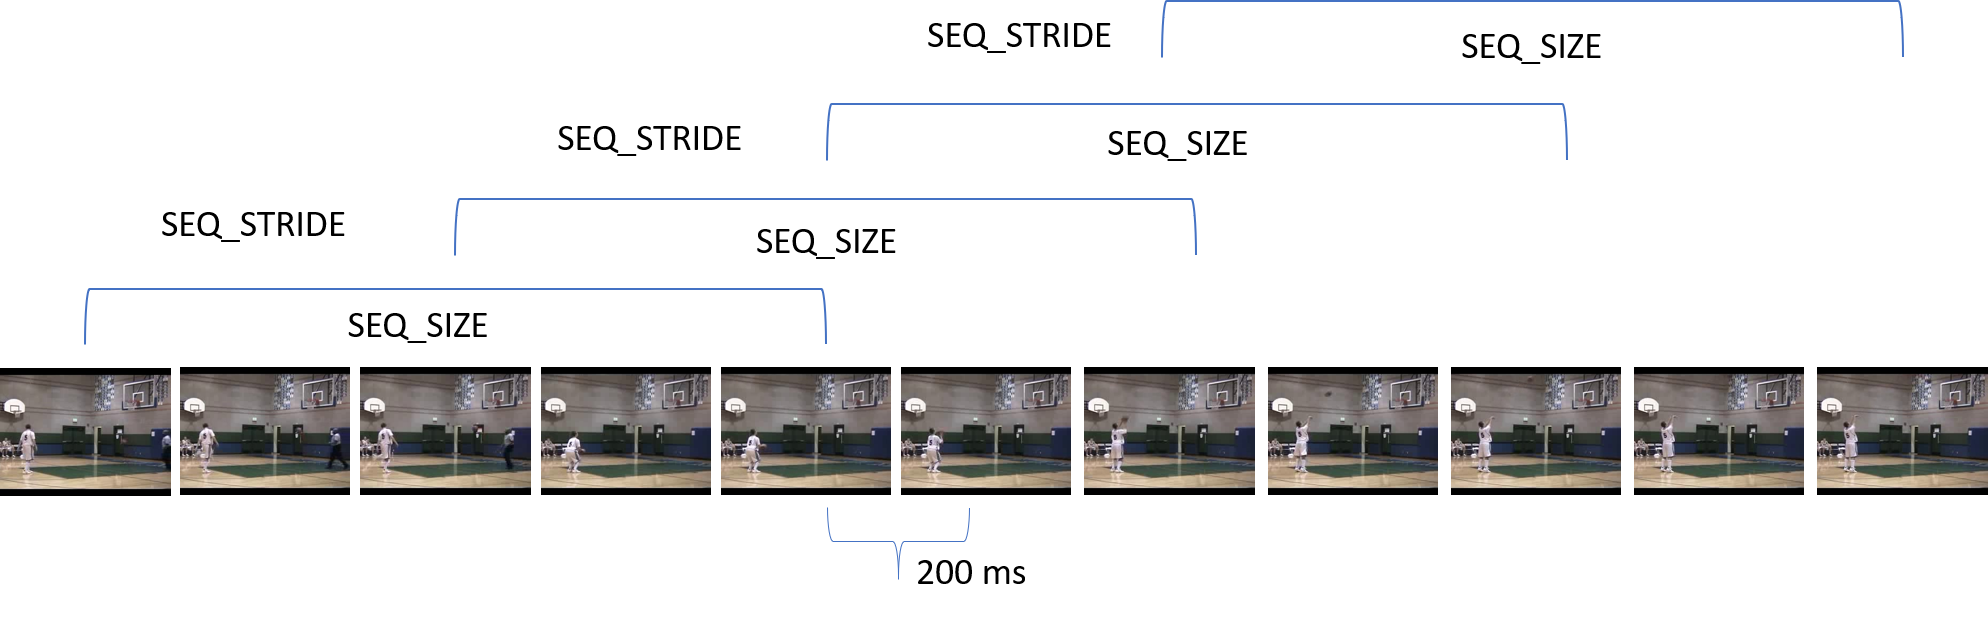

In [ ]:
#Generate clip sequences from given clip directory
def SequencesFromClipData(clip_dir,block_size,block_stride, in_out):
    img_list = sorted(glob.glob(clip_dir+"/**"))
    
    clip_size = len(img_list)
    
    if(clip_size < block_size):
        print("Clip Size is smaller than Block Size; ignoring ...")
        return 0
    
    lbl = clip_dir.rsplit('/',3)[1]
    lbl_idx = label_2_idx_dict[lbl]
    lbl_ohot = np.zeros(CLASSES,dtype=int)
    lbl_ohot[lbl_idx] = 1
    
    index = 0
    count = 0
    
    while(index + block_size < clip_size):
        tup = (img_list[index:index+block_size],lbl_ohot)
        in_out.append(tup)
        index += block_stride
        count += 1
        
    tup = (img_list[-block_size:],lbl_ohot)
    in_out.append(tup)    
    count += 1
    
    return count

#Generate clip sequences from given group directories
def SequenceFromGroupData(group_dir_list):
    tBlocks = []
    for group_dir in group_dir_list:
        clip_dir_list = sorted(glob.glob(group_dir+"/**"))        
        for clip_dir in clip_dir_list:
            SequencesFromClipData(clip_dir,SEQ_SIZE,int(SEQ_SIZE/2),tBlocks)
    return tBlocks

#Display numpy images
def DisplayImages(np_imgs):
    N = len(np_imgs)
    fig, axes = plt.subplots(nrows=1, ncols=N, figsize=(256, 256))
    
    for i in range(N):
        axes[i].imshow(np_imgs[i])
      
    fig.tight_layout()

In [ ]:
train_set = SequenceFromGroupData(train_groups)
test_set = SequenceFromGroupData(test_groups)
val_set = SequenceFromGroupData(val_groups)

print('\n')
print('Total blocks/seqs for training: {}'.format(len(train_set)))
print('Total blocks/seqs for validation: {}'.format(len(val_set)))
print('Total blocks/seqs for testing: {}'.format(len(test_set)))

train_steps = round ( len(train_set)/(BATCH_SIZE))
val_steps = round ( len(val_set)/(BATCH_SIZE))

print('\n')
#Display a random block
print(train_set[321])
print(train_set[322])

## Tensorflow Data Pipeline

In [ ]:
def RandomSaturationBrightness(images):  
    saturation = tf.random.uniform(shape=[], minval=0.75, maxval=1.0)
    brightness = tf.random.uniform(shape=[], minval=-0.1, maxval=0.1)
    
    L = len(images)
    modified = []
    for l in range(L):
      img = tf.image.adjust_saturation(images[l], saturation)
      img = tf.image.adjust_brightness(img, brightness)
      
      img = tf.clip_by_value(img, 0.0, 1.0)
      modified.append(img)
      
    return tf.stack(modified)

def AugmentData(images,label):
    images = RandomSaturationBrightness(images)
    
    return images , label

def TFDecodeImage(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [224, 224])
        
    return img

@tf.function
def TFLoadImage(image_path_list, label):
    L = len(image_path_list)
    
    images = []
    for l in range(L):
        img = TFDecodeImage(image_path_list[l])
        images.append(img)
        
    return tf.stack(images), label
        
    
def GetTFDataset(items,bsize,train=False):
    
    block_list = [block for block,lbl in items]
    label_list = [lbl for block,lbl in items]

    ds1 = tf.data.Dataset.from_tensor_slices(block_list)    
    ds2 = tf.data.Dataset.from_tensor_slices(label_list)
    ds  = tf.data.Dataset.zip((ds1, ds2)) 

    ds = ds.map(TFLoadImage, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if train==True:
        ds= ds.map(AugmentData, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds.batch(bsize, drop_remainder=True).repeat()

In [ ]:
random.shuffle(train_set)

train_ds = GetTFDataset(train_set,BATCH_SIZE,train=True)
val_ds = GetTFDataset(val_set,BATCH_SIZE)

In [ ]:
for batch in train_ds.take(1):
    print('Batch Input Shape: {}'.format(batch[0].shape))
    print('Batch Label Shape: {}'.format(batch[1].shape))
    
    seq_00 = batch[0][0]
    lbl_ohot_00 = batch[1][0].numpy()    
    
    np_imgs = []
    for tf_img in seq_00:
        np_img = tf.image.convert_image_dtype(tf_img, tf.uint8,saturate=False).numpy()
        np_imgs.append(np_img)
        
    lbl = ohot_2_label(lbl_ohot_00)
    print('One hot {} and label "{}"'.format(lbl_ohot_00,lbl))
    
    DisplayImages(np_imgs)    

## Tensorflow Model

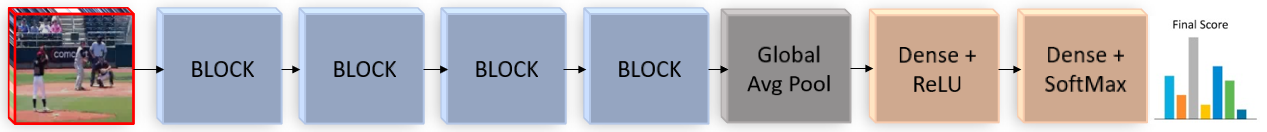

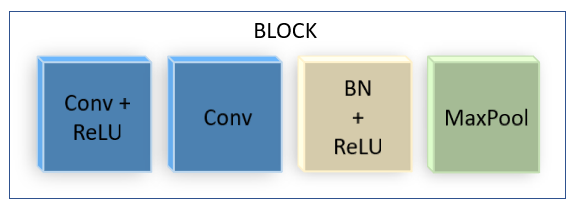

In [ ]:
def Get3DCNNModel(input_shape,nos_class):
    input_layer = Input(shape=input_shape)
    
    x = Conv3D(16, kernel_size=(3, 3 ,3), kernel_initializer='he_normal',padding='valid',activation='relu')(input_layer)
    x = Conv3D(16, kernel_size=(3, 3 ,3), kernel_initializer='he_normal',padding='valid',activation='linear')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool3D(pool_size=(1, 4, 4), strides=(1, 4, 4),padding='valid')(x)
    
    x = Conv3D(32, kernel_size=(3, 3 ,3), kernel_initializer='he_normal',padding='same',activation='relu')(x)
    x = Conv3D(32, kernel_size=(3, 3 ,3), kernel_initializer='he_normal',padding='same',activation='linear')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool3D(pool_size=(1, 4, 4), strides=(1, 4, 4),padding='valid')(x)
    
    x = Conv3D(48, kernel_size=(3, 3 ,3), kernel_initializer='he_normal',padding='same',activation='relu')(x)
    x = Conv3D(48, kernel_size=(3, 3 ,3), kernel_initializer='he_normal',padding='same',activation='linear')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2),padding='valid')(x)
    
    x = Conv3D(64, kernel_size=(3, 3 ,3), kernel_initializer='he_normal',padding='same',activation='relu')(x)
    x = Conv3D(64, kernel_size=(3, 3 ,3), kernel_initializer='he_normal',padding='same',activation='linear')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2),padding='valid')(x)
        
    x = GlobalAveragePooling3D()(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(nos_class, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=predictions)
    
    return model

In [ ]:
input_shape = (SEQ_SIZE, 224, 224, 3)

cnn3d_model = Get3DCNNModel(input_shape,CLASSES)
cnn3d_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
cnn3d_model.summary()

In [ ]:
model_ckpt = os.path.join(model_dir,'VAR_CNN-{epoch:02d}.h5')
model_cbk = ModelCheckpoint(model_ckpt, verbose=1, save_best_only=True, save_weights_only=True)

tensorBoard_cbk = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=5)

## Training model

In [ ]:
cnn3d_model.fit(train_ds,epochs=100,steps_per_epoch = train_steps,validation_data = val_ds, validation_steps = val_steps,
                   validation_freq=5,callbacks=[model_cbk,tensorBoard_cbk], verbose=1)

In [ ]:
cnn3d_model.load_weights('/content/videoactionrecognition/Model/VAR_CNN/VAR_CNN-35.h5')

## Generate Outputs

In [ ]:
random.shuffle(test_set)
test_ds = GetTFDataset(test_set,1)

cnn3d_model.evaluate(test_ds, steps = len(test_set))

In [ ]:
def GenerateOutputs(ts):    
    for ip in ts.take(5):
        op_lbl = cnn3d_model.predict(ip[0])
        
        op_lbl = ohot_2_label(tf.squeeze(op_lbl,axis=0))
        gt_lbl = ohot_2_label(ip[1])
        
        tf_imgs = tf.squeeze(ip[0],axis=0)
        np_imgs = []
        for tf_img in tf_imgs:
            np_img = tf.image.convert_image_dtype(tf_img, tf.uint8,saturate=False).numpy()
            np_imgs.append(np_img)
            
        print("Ground Truth: {} and Prediction: {}".format(gt_lbl,op_lbl))
        DisplayImages(np_imgs)

In [ ]:
GenerateOutputs(test_ds)